# Area-depth GRV Calculation

## Polygon area calculation

from [this SO page](https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import simps
from utils import *

### Contour polygons, depths and contacts definitions

In [3]:
# Contours np.array([[x], [y]]) vectors
top_0 = np.array([[8, 8, 8, 8, 8], [8, 8, 8, 8, 8]])
top_1 = np.array([[7, 9, 9, 7, 7], [7, 7, 9, 9, 7]])
top2_goc = np.array([[6, 10, 10, 6, 6], [6, 6, 10, 10, 6]])
top3 = np.array([[5, 11, 11, 5, 5], [5, 5, 11, 11, 5]])
top4 = np.array([[4, 12, 12, 4, 4], [4, 4, 12, 12, 4]])
top5_owc = np.array([[3, 13, 13, 3, 3], [3, 3, 13, 13, 3]])
# depths of polygons
top_depths = np.array([-1200, -1250, -1380, -1500, -1590, -1720])
base_depths = top_depths - 100
# contacts
goc, owc = -1380, -1720

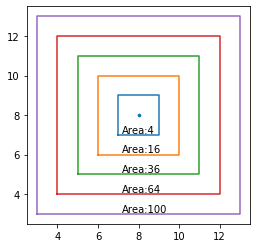

In [4]:
areas, cs = calc_areas_from_countour_set(top_0, top_1, top2_goc, top3, top4, top5_owc)
fig = plt.figure(figsize=(4, 4))
plt.scatter(top_0[0], top_0[1], s=5)
for c in cs[1:]:
    plt.plot(c[0], c[1])
    plt.text(7.2, c[0,0] + 0.1, f'Area:{poly_area(c[0], c[1]):.0f}')

## Example GRV calculation

1. plot top, base and contacts

The `HCGRV` (hydrocarbon gross-rock-volume) is the polygon defined between:
- top
- base
- OWC

The `GGRV` (gas gross-rock-volume) is the polygon defined between:
- top
- base
- GOC

The `OGRV` (oil gross-rock-volume) is the difference between
`HCGRV - GGRV`

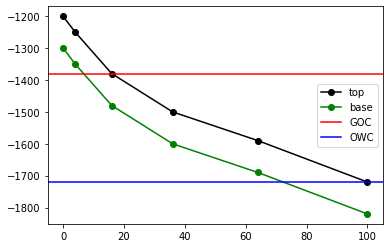

In [5]:
plt.plot(areas, top_depths, '-o', c='k', label='top')
plt.plot(areas, base_depths, '-o', c='g', label='base')
plt.axhline(goc, c='r', label='GOC')
plt.axhline(owc, c='b', label='OWC')
plt.legend()

2. Calculate intersection of `goc` and `owc` with base

In [6]:
c0, c1 = closest_depths_to_contact(base_depths, goc)
a0, a1 = closest_areas_to_contact(areas, base_depths, c0, c1)
m = last_base_slope(c0, c1, a0, a1)
x = calc_x_for_contact_depth(m, c0, goc)
x_act_goc = calc_x_actual(x, a0)

c0, c1 = closest_depths_to_contact(base_depths, owc)
a0, a1 = closest_areas_to_contact(areas, base_depths, c0, c1)
m = last_base_slope(c0, c1, a0, a1)
x = calc_x_for_contact_depth(m, c0, owc)
x_act_owc = calc_x_actual(x, a0)

3. Plot top, base, contacts and intersections

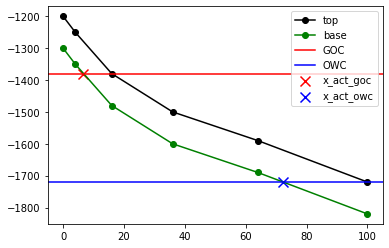

In [7]:
plt.plot(areas, top_depths, '-o', c='k', label='top')
plt.plot(areas, base_depths, '-o', c='g', label='base')
plt.axhline(goc, c='r', label='GOC')
plt.axhline(owc, c='b', label='OWC')
plt.scatter(x_act_goc, goc, c='r', marker='x', s=100, label='x_act_goc')
plt.scatter(x_act_owc, owc, c='b', marker='x', s=100, label='x_act_owc')
plt.legend()

4. Add `x_act_goc` and `x_act_owc` to `base_depths` arrays

In [8]:
# insert x_act_goc and x_act_owc into areas vector
idx_areas_xgoc = np.searchsorted(areas, x_act_goc)
areas_contacts = np.insert(areas, idx_areas_xgoc, x_act_goc)
idx_areas_xowc = np.searchsorted(areas_contacts, x_act_owc)
areas_contacts = np.insert(areas_contacts, idx_areas_xowc, x_act_owc)

# insert x_act_goc and x_act_owc into base_depths vector
idx_base_depths_goc = np.searchsorted(base_depths[::-1], goc)
base_depths_contacts = np.insert(base_depths[::-1], idx_base_depths_goc, goc)[::-1]
idx_base_depths_owc = np.searchsorted(base_depths_contacts[::-1], owc)
base_depths_contacts = np.insert(base_depths_contacts[::-1], idx_base_depths_owc, owc)[::-1]

5. Build polygon for `HCGRV` and `GGRV`

For `HCGRV` we need all points in `base_depths_contacts` down to `owc`, then in reverse order all points in `top_depths`.
For `GGRV` we need all points in `base_depths_contacts` only down to `goc`, then in reverse order all points from `goc` depth to crest in `top_depths`.

In [9]:
base_xs_owc = areas_contacts[base_depths_contacts >= owc]
base_ys_owc = base_depths_contacts[base_depths_contacts >= owc]
top_xs_owc = areas[top_depths >= owc]
top_ys_owc = top_depths[top_depths >= owc]
owc_xs = np.append(base_xs_owc, top_xs_owc[::-1])
owc_ys = np.append(base_ys_owc, top_ys_owc[::-1])

In [10]:
base_xs_goc = areas_contacts[areas_contacts <= x_act_goc]
base_ys_goc = base_depths_contacts[base_depths_contacts >= goc]
top_xs_goc = areas[top_depths >= goc]
top_ys_goc = top_depths[top_depths >= goc]
goc_xs = np.append(base_xs_goc, top_xs_goc[::-1])
goc_ys = np.append(base_ys_goc, top_ys_goc[::-1])

6. Calculate `HCGRV` and `GGRV` with `poly_area` and `OGRV` with difference between `HCGRV` and `GGRV`

In [11]:
HCGRV = poly_area(owc_xs, owc_ys)
GGRV = poly_area(goc_xs, goc_ys)
OGRV = HCGRV - GGRV
print(f'HCGRV: {HCGRV:.0f}\nGGRV: {GGRV:.0f}\nOGRV: {OGRV:.0f}')

HCGRV: 8639
GGRV: 1144
OGRV: 7495


## Testing

Build an analytical case and test it with code above.

In [12]:
a, A, a_, A_ = get_sq_root(100)
a, A, a_, A_

(100, 10000, 70.71067811865476, 5000.0)

In [13]:
# Contours np.array([[x], [y]]) vectors
top0_crest = np.array([np.ones(5) * 50, np.ones(5) * 50])
top1_goc = np.array([[0, a_, a_, 0, 0], [0, 0, a_, a_, 0]])
top2_owc = np.array([[0, 100, 100, 0, 0], [0, 0, 100, 100, 0]])
# depths of polygons
top_depths = np.array([0, -50, -100])
base_depths = top_depths - 50
# contacts
goc, owc = -50, -100

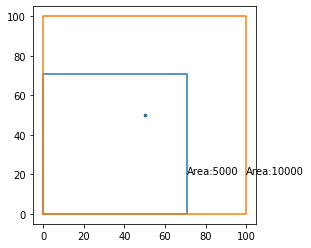

In [14]:
areas, cs = calc_areas_from_countour_set(top0_crest, top1_goc, top2_owc)
fig = plt.figure(figsize=(4, 4))
plt.scatter(top0_crest[0], top0_crest[1], s=5)
for c in cs[1:]:
    plt.plot(c[0], c[1])
    plt.text(c[0, 1], 20, f'Area:{poly_area(c[0], c[1]):.0f}')

In [15]:
c0, c1 = closest_depths_to_contact(base_depths, goc)
a0, a1 = closest_areas_to_contact(areas, base_depths, c0, c1)
m = last_base_slope(c0, c1, a0, a1)
x = calc_x_for_contact_depth(m, c0, goc)
x_act_goc = calc_x_actual(x, a0)

c0, c1 = closest_depths_to_contact(base_depths, owc)
a0, a1 = closest_areas_to_contact(areas, base_depths, c0, c1)
m = last_base_slope(c0, c1, a0, a1)
x = calc_x_for_contact_depth(m, c0, owc)
x_act_owc = calc_x_actual(x, a0)

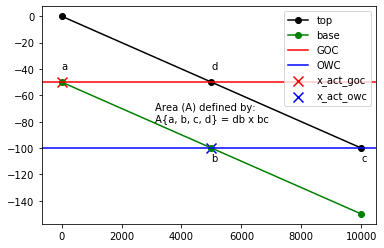

In [16]:
plt.plot(areas, top_depths, '-o', c='k', label='top')
plt.plot(areas, base_depths, '-o', c='g', label='base')
plt.axhline(goc, c='r', label='GOC')
plt.axhline(owc, c='b', label='OWC')
plt.scatter(x_act_goc, goc, c='r', marker='x', s=100, label='x_act_goc')
plt.scatter(x_act_owc, owc, c='b', marker='x', s=100, label='x_act_owc')
plt.text(x_act_goc, -40, 'a')
plt.text(areas[1], -40, 'd')
plt.text(x_act_owc, -110, 'b')
plt.text(areas[2], -110, 'c')
plt.text(3100, -80, 'Area (A) defined by:\nA{a, b, c, d} = db x bc')
plt.legend()

In [17]:
# insert x_act_goc and x_act_owc into areas vector
idx_areas_xgoc = np.searchsorted(areas, x_act_goc)
areas_contacts = np.insert(areas, idx_areas_xgoc, x_act_goc)
idx_areas_xowc = np.searchsorted(areas_contacts, x_act_owc)
areas_contacts = np.insert(areas_contacts, idx_areas_xowc, x_act_owc)

# insert x_act_goc and x_act_owc into base_depths vector
idx_base_depths_goc = np.searchsorted(base_depths[::-1], goc)
base_depths_contacts = np.insert(base_depths[::-1], idx_base_depths_goc, goc)[::-1]
idx_base_depths_owc = np.searchsorted(base_depths_contacts[::-1], owc)
base_depths_contacts = np.insert(base_depths_contacts[::-1], idx_base_depths_owc, owc)[::-1]

In [18]:
base_xs_owc = areas_contacts[base_depths_contacts >= owc]
base_ys_owc = base_depths_contacts[base_depths_contacts >= owc]
top_xs_owc = areas[top_depths >= owc]
top_ys_owc = top_depths[top_depths >= owc]
owc_xs = np.append(base_xs_owc, top_xs_owc[::-1])
owc_ys = np.append(base_ys_owc, top_ys_owc[::-1])

In [19]:
base_xs_goc = areas_contacts[areas_contacts <= x_act_goc]
base_ys_goc = base_depths_contacts[base_depths_contacts >= goc]
top_xs_goc = areas[top_depths >= goc]
top_ys_goc = top_depths[top_depths >= goc]
goc_xs = np.append(base_xs_goc, top_xs_goc[::-1])
goc_ys = np.append(base_ys_goc, top_ys_goc[::-1])

In [20]:
HCGRV = poly_area(owc_xs, owc_ys)
GGRV = poly_area(goc_xs, goc_ys)
OGRV = HCGRV - GGRV
print(f'HCGRV: {HCGRV:.0f}\nGGRV: {GGRV:.0f}\nOGRV: {OGRV:.0f}')

HCGRV: 375000
GGRV: 125000
OGRV: 250000


In [21]:
assert (100-50) * (10000-5000) == OGRV